In [110]:
import openpyxl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
import datetime
import math
import pandas as pd
from scipy import stats
import seaborn as sn

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

# Drops specific values in a dataframe
# if flag = 1, drops values less than 'val'
# if flag = 0, drops values greater than 'val'
def drop_values(dataframe, column, val, flag):
    if flag:
        return dataframe.drop(dataframe[column < val].index)
    else:
        return dataframe.drop(dataframe[column > val].index)
    
# Normalize the data
def norm(dataframe):
    return (dataframe - dataframe.describe().transpose()['mean'] / dataframe.describe().transpose()['std'])

# Air Quality Health Factor Function
# Pass NO2 concentration in ppb
# Pass O3 concentration in ppb
# Pass PM2.5 concentration in ug/m^3
def AQHI(NO2, O3, PM25):
    NO2_CONST = 0.000871
    O3_CONST = 0.000537
    PM25_CONST = 0.000487
    return((10/10.4)*100*(np.exp(NO2_CONST*NO2)-1+np.exp(O3_CONST*O3)-1+np.exp(PM25_CONST*PM25)-1))

# Remove outliers
def remove_outliers(dataframe):
    return dataframe[(np.abs(stats.zscore(dataframe)) < 3).all(axis=1)]
    
# Read in the egg sensor datasets
EGG1 = pd.read_pickle('pkl_datasets/EGG1_DATASET_3h.pkl')
EGG2 = pd.read_pickle('pkl_datasets/EGG2_DATASET_3h.pkl')
EGG4 = pd.read_pickle('pkl_datasets/EGG4_DATASET_3h.pkl')
# Drop columns
EGG1 = EGG1.drop(columns=['PM1.0[ug/m^3]', 'PM10.0[ug/m^3]',
                          'Temperature[degC]', 'Humidity[percent]', 'Pressure[Pa]',
                          'PM10_conc', 'PM10-2.5_conc', 'Air_Temperature', 'Relative_Humidity',
                          'O3[V]', 'NO2[V]', 'NO', 'NOx'])
EGG2 = EGG2.drop(columns=['PM1.0[ug/m^3]', 'PM10.0[ug/m^3]',
                          'Temperature[degC]', 'Humidity[percent]', 'Pressure[Pa]',
                          'PM10_conc', 'PM10-2.5_conc', 'Air_Temperature', 'Relative_Humidity',
                          'O3[V]', 'NO2[V]', 'NO', 'NOx'])
EGG4 = EGG4.drop(columns=['PM1.0[ug/m^3]', 'PM10.0[ug/m^3]',
                          'Temperature[degC]', 'Humidity[percent]', 'Pressure[Pa]',
                          'PM10_conc', 'PM10-2.5_conc', 'Air_Temperature', 'Relative_Humidity',
                          'O3[V]', 'NO2[V]', 'NO', 'NOx'])
# Compute AQHI for each egg
# EGG 1
EGG1['AQHI_EGG1'] = AQHI(EGG1['NO2[ppb]'], EGG1['O3[ppb]'], EGG1['PM2.5[ug/m^3]'])
EGG1['AQHI_Airpointer'] = AQHI(EGG1['NO2'], EGG1['O3'], EGG1['PM2.5_conc'])
# EGG 2
EGG2['AQHI_EGG2'] = AQHI(EGG2['NO2[ppb]'], EGG2['O3[ppb]'], EGG2['PM2.5[ug/m^3]'])
EGG2['AQHI_Airpointer'] = AQHI(EGG2['NO2'], EGG2['O3'], EGG2['PM2.5_conc'])
# EGG 4
EGG4['AQHI_EGG4'] = AQHI(EGG4['NO2[ppb]'], EGG4['O3[ppb]'], EGG4['PM2.5[ug/m^3]'])
EGG4['AQHI_Airpointer'] = AQHI(EGG4['NO2'], EGG4['O3'], EGG4['PM2.5_conc'])

EGG2 = EGG2.iloc[3:]
EGG4 = EGG4.iloc[3:]

EGG2.head()

PM2.5[ug/m^3]    O3[ppb]   NO2[ppb]        NO2  \
Timestamp                                                             
2020-05-06 21:00:00       1.474444  51.298333  90.249444   4.503333   
2020-05-07 00:00:00      11.993333  52.406556  86.826833   7.564000   
2020-05-07 03:00:00      21.506111  53.416389  86.454944  11.680333   
2020-05-07 06:00:00       6.487222  51.351944  82.603444   9.254333   
2020-05-07 09:00:00       2.069444  49.383944  86.663111   3.366000   

                            O3  PM2.5_conc  AQHI_EGG2  AQHI_Airpointer  
Timestamp                                                               
2020-05-06 21:00:00  35.328333    3.288667  10.618061         2.373595  
2020-05-07 00:00:00  30.056000    3.689667  10.861462         2.373029  
2020-05-07 03:00:00  25.259000    3.518667  11.330623         2.461255  
2020-05-07 06:00:00  30.296667    3.974333  10.165677         2.541620  
2020-05-07 09:00:00  39.895667    3.859000  10.219979         2.545414

In [111]:
EGG2['new'] = EGG2['NO2[ppb]'] - EGG2['O3']

In [112]:
EGG2

PM2.5[ug/m^3]    O3[ppb]    NO2[ppb]        NO2  \
Timestamp                                                              
2020-05-06 21:00:00       1.474444  51.298333   90.249444   4.503333   
2020-05-07 00:00:00      11.993333  52.406556   86.826833   7.564000   
2020-05-07 03:00:00      21.506111  53.416389   86.454944  11.680333   
2020-05-07 06:00:00       6.487222  51.351944   82.603444   9.254333   
2020-05-07 09:00:00       2.069444  49.383944   86.663111   3.366000   
...                            ...        ...         ...        ...   
2020-06-11 00:00:00       4.748333  55.292778  122.782611  11.085000   
2020-06-11 03:00:00       4.533889  52.463389  123.766667   5.566000   
2020-06-11 06:00:00       1.198333  41.904111  111.653889   3.981333   
2020-06-11 09:00:00       0.117222  50.866278   79.331667   2.632333   
2020-06-11 12:00:00       1.339130  55.471522   94.126087   2.831000   

                            O3  PM2.5_conc  AQHI_EGG2  AQHI_Airpointer  \
Timestamp                                                                
2020-05-06 21:00:00  35.328333    3.288667  10.618061         2.373595   
2020-05-07 00:00:00  30.056000    3.689667  10.861462         2.373029   
2020-05-07 03:00:00  25.259000    3.518667  11.330623         2.461255   
2020-05-07 06:00:00  30.296667    3.974333  10.165677         2.541620   
2020-05-07 09:00:00  39.895667    3.859000  10.219979         2.545414   
...                        ...         ...        ...              ...   
2020-06-11 00:00:00  42.265667    5.162000  13.973470         3.382216   
2020-06-11 03:00:00  39.194333    5.695000  13.904779         2.779566   
2020-06-11 06:00:00  18.223333    2.985333  12.065175         1.419485   
2020-06-11 09:00:00  22.747333    1.586000   9.547101         1.476760   
2020-06-11 12:00:00  25.151000    2.816000  11.185282         1.676816   

                           new  
Timestamp                       
2020-05-06 21:00:00  54.921111  
2020-05-07 00:00:00  56.770833  
2020-05-07 03:00:00  61.195944  
2020-05-07 06:00:00  52.306778  
2020-05-07 09:00:00  46.767444  
...                        ...  
2020-06-11 00:00:00  80.516944  
2020-06-11 03:00:00  84.572333  
2020-06-11 06:00:00  93.430556  
2020-06-11 09:00:00  56.584333  
2020-06-11 12:00:00  68.975087  

[286 rows x 9 columns]

In [113]:
EGG2['AQHI_EGG2'] = AQHI(EGG2['new'], EGG2['O3'], EGG2['PM2.5[ug/m^3]'])
EGG2['AQHI_Airpointer'] = AQHI(EGG2['NO2'], EGG2['O3'], EGG2['PM2.5_conc'])

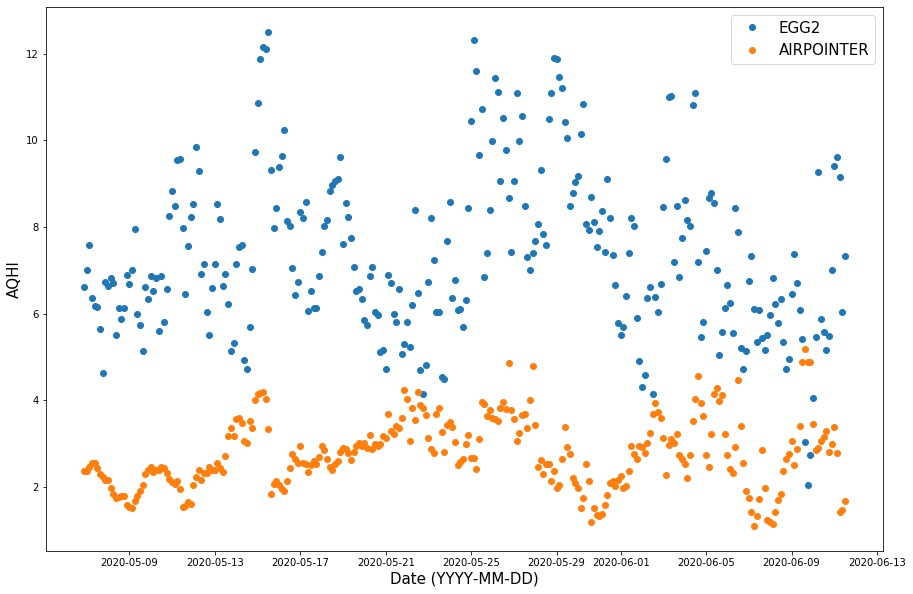

In [114]:
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['AQHI_EGG2'], 'o', label="EGG2")
plt.plot(EGG2.index.to_series(), EGG2['AQHI_Airpointer'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('AQHI', fontsize=15)
plt.legend(loc='best', fontsize=15)

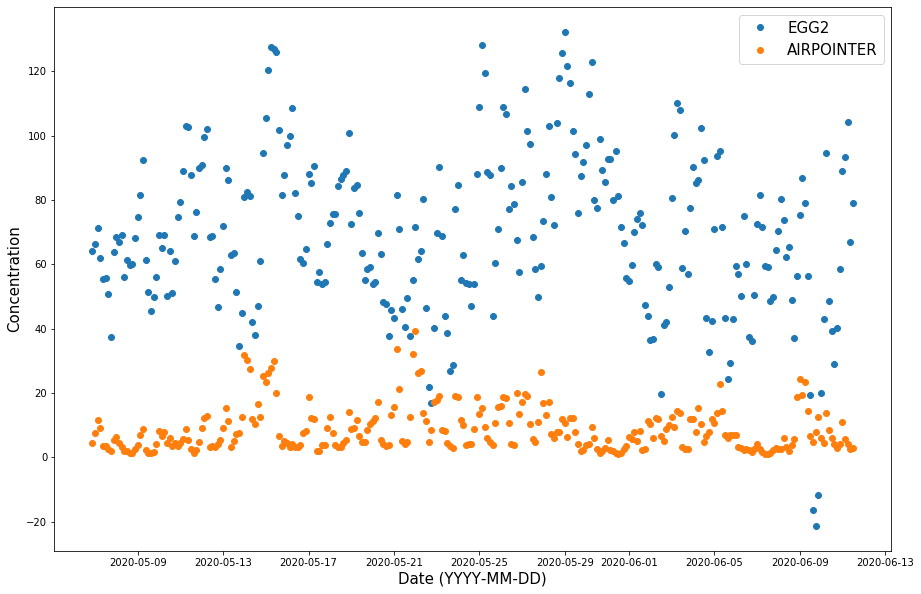

In [78]:
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['NO2[ppb]']-EGG2['O3']/0.9044+12.8151, 'o', label="EGG2")
plt.plot(EGG2.index.to_series(), EGG2['NO2'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('Concentration', fontsize=15)
plt.legend(loc='best', fontsize=15)

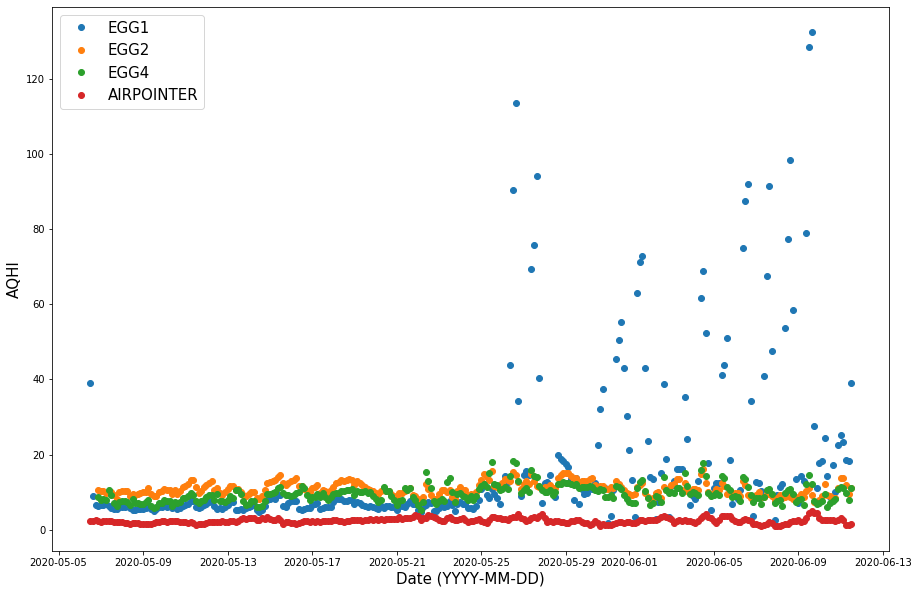

In [41]:
# ----------------------------- AQHI FROM AIRPOINTER vs. AQHI FROM CLUSTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(EGG1.index.to_series(), EGG1['AQHI_EGG1'], 'o', label="EGG1")
plt.plot(EGG2.index.to_series(), EGG2['AQHI_EGG2'], 'o', label="EGG2")
plt.plot(EGG4.index.to_series(), EGG4['AQHI_EGG4'], 'o', label="EGG4")
plt.plot(EGG1.index.to_series(), EGG1['AQHI_Airpointer'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('AQHI', fontsize=15)
plt.legend(loc='best', fontsize=15)

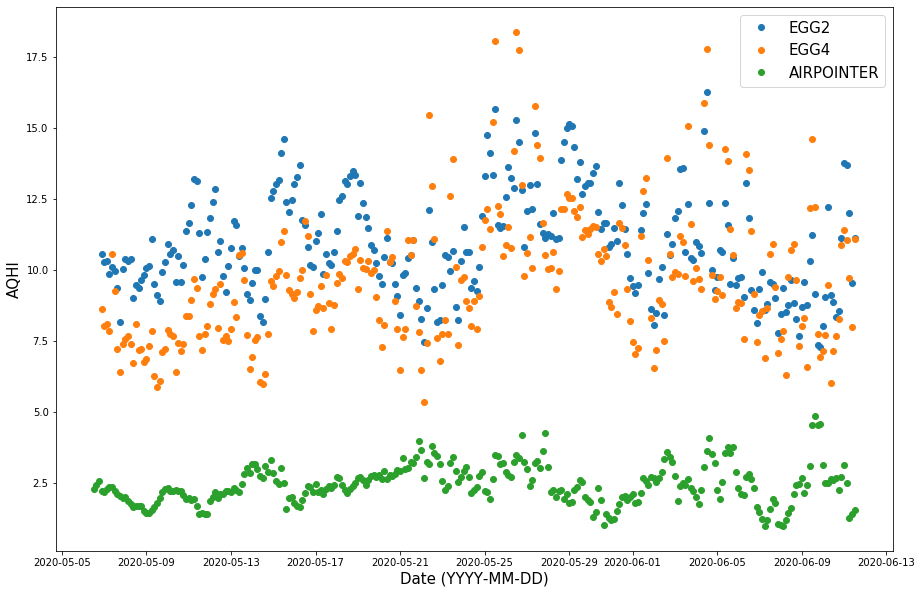

In [43]:
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['AQHI_EGG2'], 'o', label="EGG2")
plt.plot(EGG4.index.to_series(), EGG4['AQHI_EGG4'], 'o', label="EGG4")
plt.plot(EGG1.index.to_series(), EGG1['AQHI_Airpointer'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('AQHI', fontsize=15)
plt.legend(loc='best', fontsize=15)

In [53]:
# --------------------- BUILD TRAINING AND TEST SETS -------------------------------------
# TRAINING DATA
training_data = drop_values(EGG2, EGG2.index, '2020-06-05 16:00:00', 0)
DATA_train = training_data['AQHI_EGG2'].to_numpy()
target_train = training_data['AQHI_Airpointer'].to_numpy()
# TEST DATA
testing_data = drop_values(EGG2, EGG2.index, '2020-06-05 17:00:00', 1)
DATA_test = testing_data['AQHI_EGG2'].to_numpy()
target_test = testing_data['AQHI_Airpointer'].to_numpy()

In [59]:
# --------------------------- TRAIN THE LINEAR REGRESSION MODEL ---------------------------
lr = LinearRegression().fit(DATA_train.reshape(-1,1), target_train)
print("TRAINING PERFORMANCE:")
print("Training set score: {:0.6f}".format(lr.score(DATA_train.reshape(-1,1), target_train)))
print('MAE: {:0.4f}\n'.format(metrics.mean_absolute_error(target_train, lr.predict(DATA_train.reshape(-1,1)))))
print("TEST PERFROMANCE:")
print("Training set score: {:0.6f}".format(lr.score(DATA_test.reshape(-1,1), target_test)))
print('MAE: {:0.4f}\n'.format(metrics.mean_absolute_error(target_test, lr.predict(DATA_test.reshape(-1,1)))))
for i in range(len(DATA_train_dataframe.columns)):
    print("{}: {}".format(DATA_train_dataframe.columns[i], lr.coef_[i]))
print('\nIntercept: ', lr.intercept_)

TRAINING PERFORMANCE:
Training set score: 0.002446
MAE: 0.4977

TEST PERFROMANCE:
Training set score: -0.034210
MAE: 0.7526

AQHI_EGG2: -0.017998293985433483

Intercept:  2.6730753807889447


In [ ]:
plt.figure(figsize=(15,10))
plt.plot(testing_data.index.to_series(), lr.predict(, 'o', label="EGG2")
plt.plot(EGG1.index.to_series(), EGG1['AQHI_Airpointer'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('AQHI', fontsize=15)
plt.legend(loc='best', fontsize=15)

0.06189202007990535

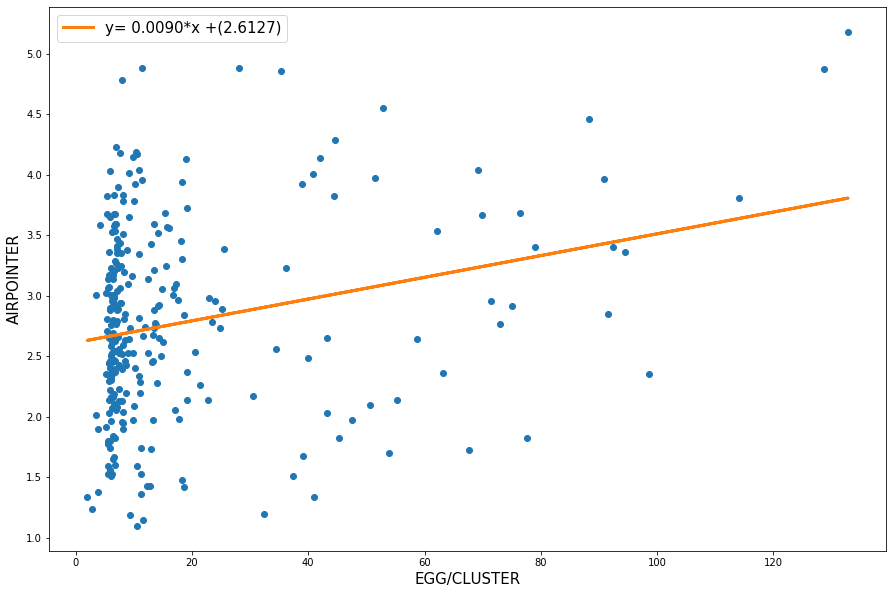

In [115]:
# Calculate a regression line
# Egg sensor
xValues = EGG1['AQHI_EGG1'].to_numpy()
# Airpointer
yValues = EGG1['AQHI_Airpointer'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.0020199559519941124

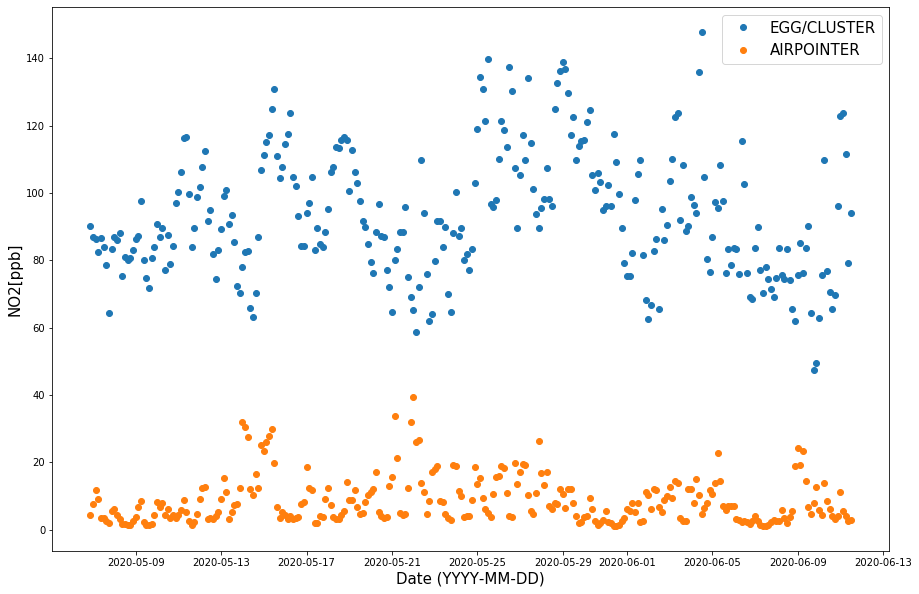

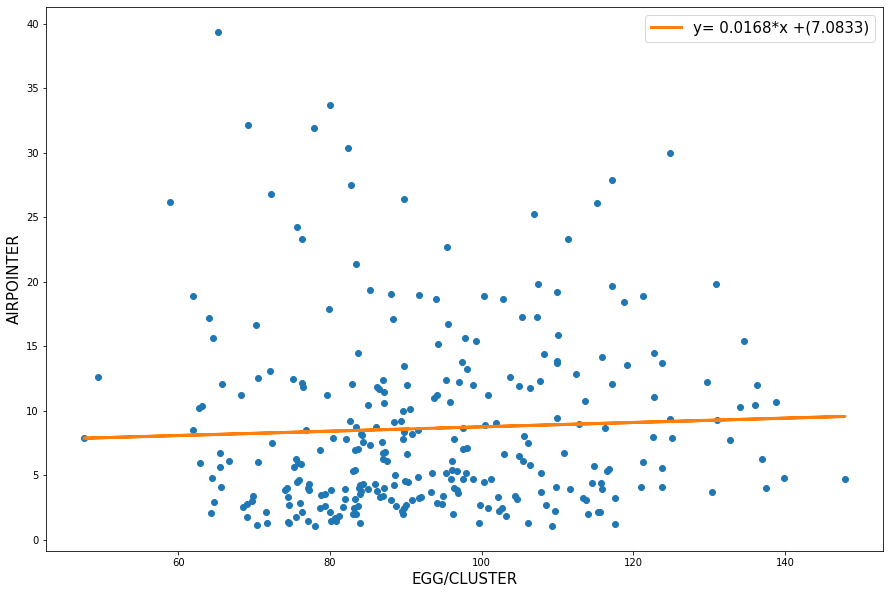

In [106]:
# ----------------------------- NO2 FROM EGG2 vs. NO2 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['NO2[ppb]'], 'o', label="EGG/CLUSTER")
plt.plot(EGG2.index.to_series(), EGG2['NO2'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = EGG2['NO2[ppb]'].to_numpy()
# Airpointer
yValues = EGG2['NO2'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.0020199559519941124

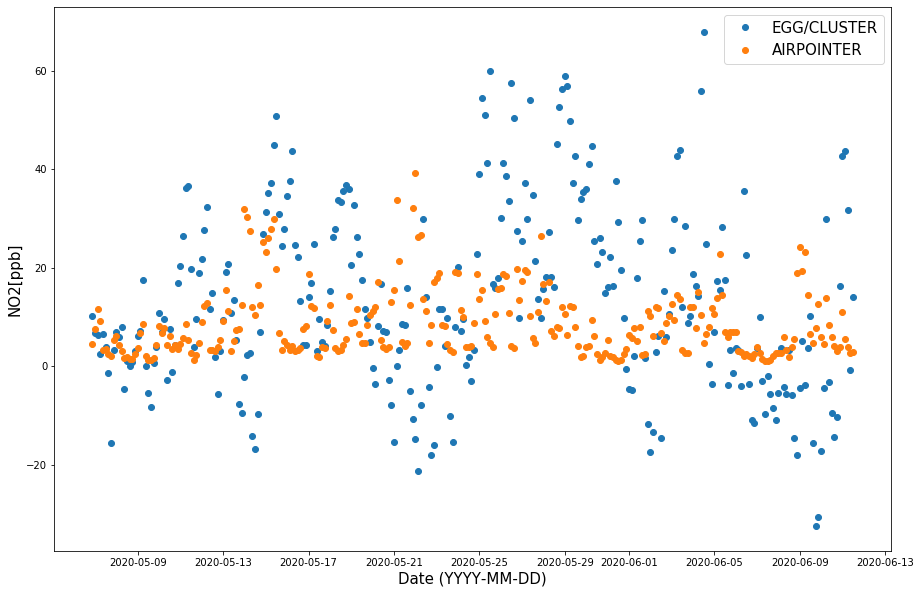

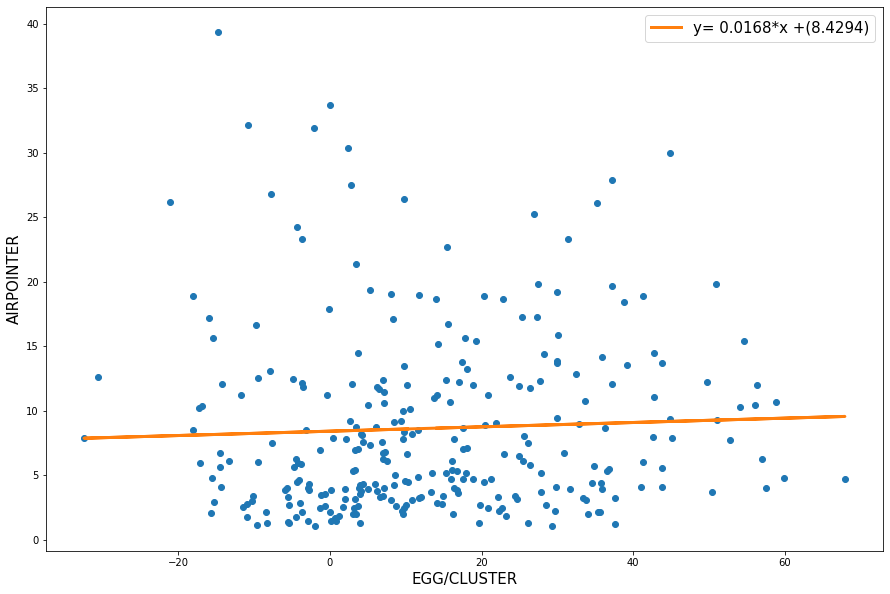

In [109]:
# ----------------------------- NO2 FROM EGG2 vs. NO2 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['NO2[ppb]']-80, 'o', label="EGG/CLUSTER")
plt.plot(EGG2.index.to_series(), EGG2['NO2'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = (EGG2['NO2[ppb]']-80).to_numpy()
# Airpointer
yValues = EGG2['NO2'].to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

0.3488248829526228

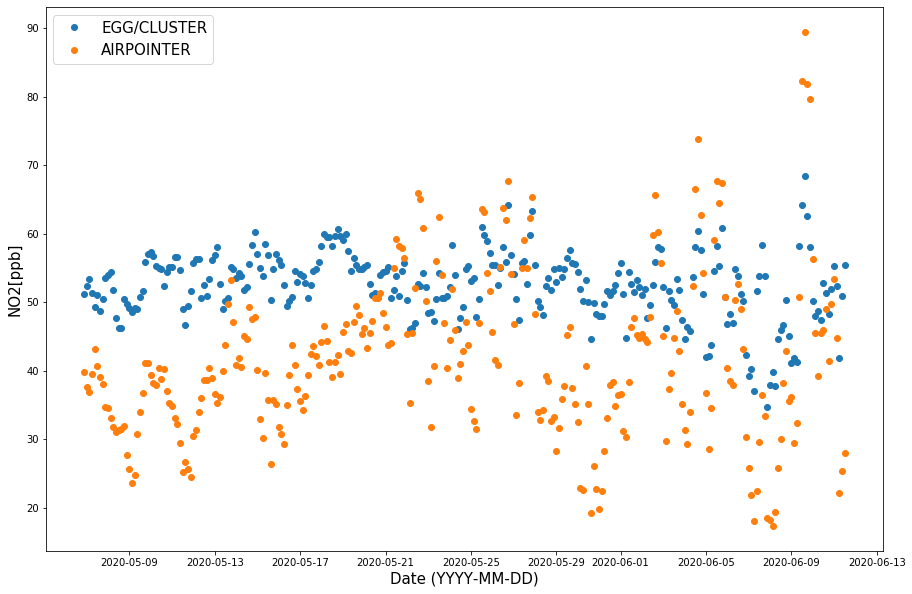

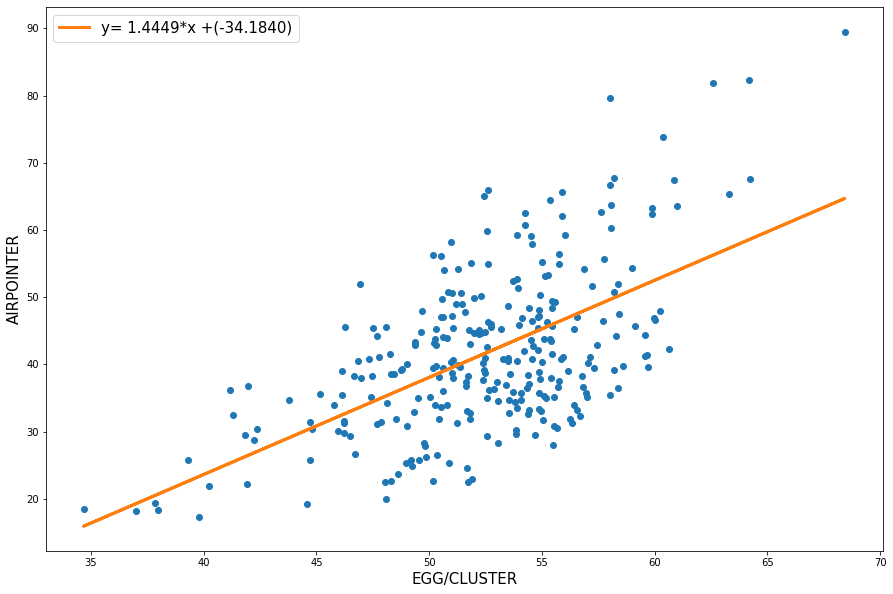

In [116]:
# ----------------------------- NO2 FROM CLUSTER vs. NO2 FROM AIRPOINTER ----------------------------------------
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['O3[ppb]'], 'o', label="EGG/CLUSTER")
plt.plot(EGG2.index.to_series(), (EGG2['NO2']+EGG2['O3']), 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = (EGG2['O3[ppb]']).to_numpy()
# Airpointer
yValues = (EGG2['NO2']+EGG2['O3']).to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))

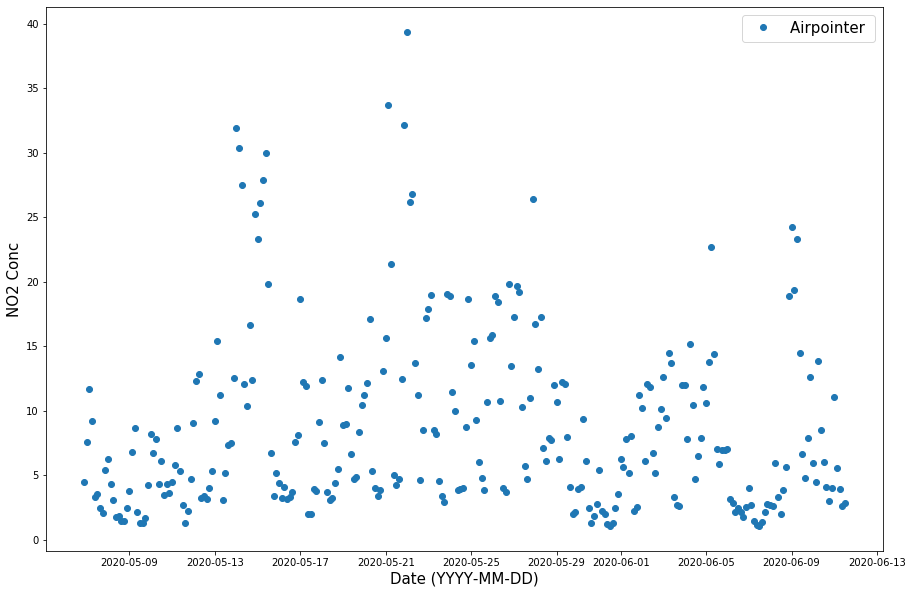

In [87]:
plt.figure(figsize=(15,10))
plt.plot(EGG2.index.to_series(), EGG2['NO2'], 'o', label="Airpointer ")
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2 Conc', fontsize=15)
plt.legend(loc='best', fontsize=15)

In [90]:
EGG1_daily = pd.read_pickle('pkl_datasets/EGG1_DAILY.pkl')
EGG2_daily = pd.read_pickle('pkl_datasets/EGG2_DAILY.pkl')
EGG4_daily = pd.read_pickle('pkl_datasets/EGG4_DAILY.pkl')

In [93]:
EGG2_daily

Temperature[degC]  Humidity[percent]  PM1.0[ug/m^3]  \
Timestamp                                                         
2020-05-06          16.241046          23.562766       1.237268   
2020-05-07          12.020062          35.003264       6.634722   
2020-05-08           7.524521          32.896076       3.632083   
2020-05-09           6.000556          42.243500       5.010208   
2020-05-10           8.814972          46.753375       5.207292   
2020-05-11           8.490340          51.637451       6.280069   
2020-05-12           8.798785          37.122340       6.561875   
2020-05-13          12.848410          31.200431       5.151875   
2020-05-14          11.422750          45.936694      10.251458   
2020-05-15          15.081035          66.486444      13.470278   
2020-05-16          17.051709          53.779226       4.947773   
2020-05-17          16.562569          48.316028       5.038194   
2020-05-18          15.126069          67.143090       4.475139   
2020-05-19          18.210986          31.835514       2.159375   
2020-05-20          20.031333          32.470069       2.489861   
2020-05-21          19.718042          27.894243       2.852917   
2020-05-22          24.300063          31.032682       5.974983   
2020-05-23          26.313000          41.736667       7.314792   
2020-05-24          25.314083          44.419562       6.473333   
2020-05-25          29.559802          50.862596      11.493288   
2020-05-26          30.258563          46.225250      15.723611   
2020-05-27          30.005549          43.925944      11.784583   
2020-05-28          24.642208          59.139583       6.818819   
2020-05-29          23.665458          60.001326       6.794444   
2020-05-30          19.324576          49.635014       2.365278   
2020-05-31          17.657736          37.367819       0.792292   
2020-06-01          22.369833          30.999271       2.745417   
2020-06-02          22.429338          43.190163       4.481289   
2020-06-03          24.774035          52.261167      12.215694   
2020-06-04          29.625368          40.052111       8.131042   
2020-06-05          29.587646          43.268167      11.054861   
2020-06-06          27.447535          35.489903       4.833333   
2020-06-07          23.716456          37.384392       2.697429   
2020-06-08          24.916368          33.336764       2.689167   
2020-06-09          30.599194          34.020569       5.512292   
2020-06-10          29.380715          47.496535       9.266250   
2020-06-11          24.219191          54.603185       1.630809   

            PM2.5[ug/m^3]  PM10.0[ug/m^3]    O3[ppb]     O3[V]    NO2[ppb]  \
Timestamp                                                                    
2020-05-06       2.198482        2.489039  51.630371  1.426296  147.383777   
2020-05-07       8.637986        9.113333  51.295438  1.426058   81.629646   
2020-05-08       4.641042        5.107569  50.083833  1.425852   82.734167   
2020-05-09       6.133125        6.548889  51.447771  1.425752   82.777222   
2020-05-10       7.362153        7.844861  55.157146  1.425802   86.568194   
2020-05-11       8.272431        8.985625  52.501306  1.425846  101.466299   
2020-05-12       8.900625        9.828333  54.013799  1.425836   93.498208   
2020-05-13       7.737431        8.447083  53.416917  1.426092   87.752618   
2020-05-14      16.213403       17.608750  54.993826  1.425931   79.542764   
2020-05-15      24.292917       30.189583  55.450958  1.426131  115.352299   
2020-05-16       7.464085        7.836496  53.174637  1.426321  107.224671   
2020-05-17       7.609236        8.047222  53.638278  1.426273   90.770937   
2020-05-18       6.420139        6.751042  59.456882  1.426042  110.606993   
2020-05-19       3.365000        3.665278  56.607583  1.426314   98.316076   
2020-05-20       3.825903        4.205486  53.146674  1.426519   83.079174   
2020-05-21       4.192361        4.589444  53.409681  1.426510   80.6758

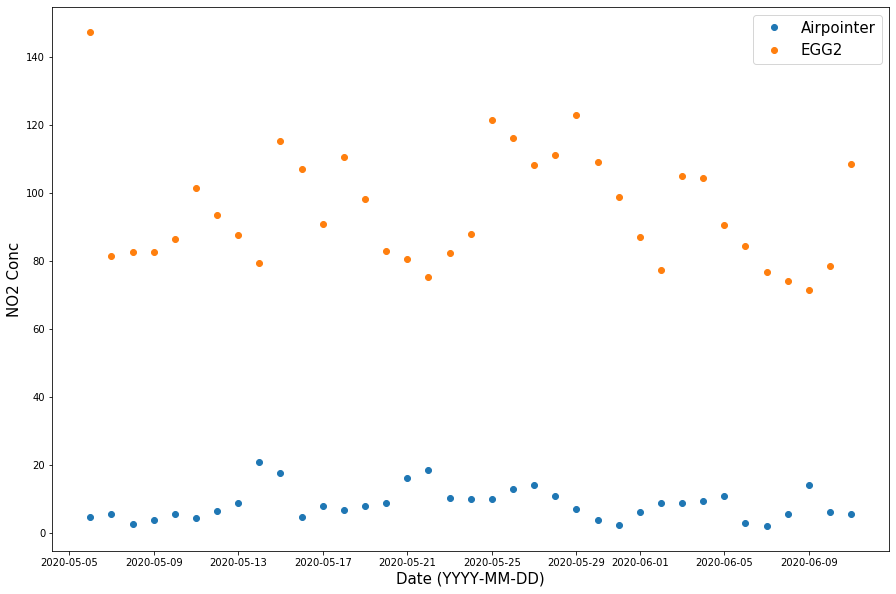

In [98]:
plt.figure(figsize=(15,10))
plt.plot(EGG2_daily.index.to_series(), EGG2_daily['NO2'], 'o', label="Airpointer")
plt.plot(EGG2_daily.index.to_series(), EGG2_daily['NO2[ppb]'], 'o', label="EGG2")
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2 Conc', fontsize=15)
plt.legend(loc='best', fontsize=15)

0.004907213727708193

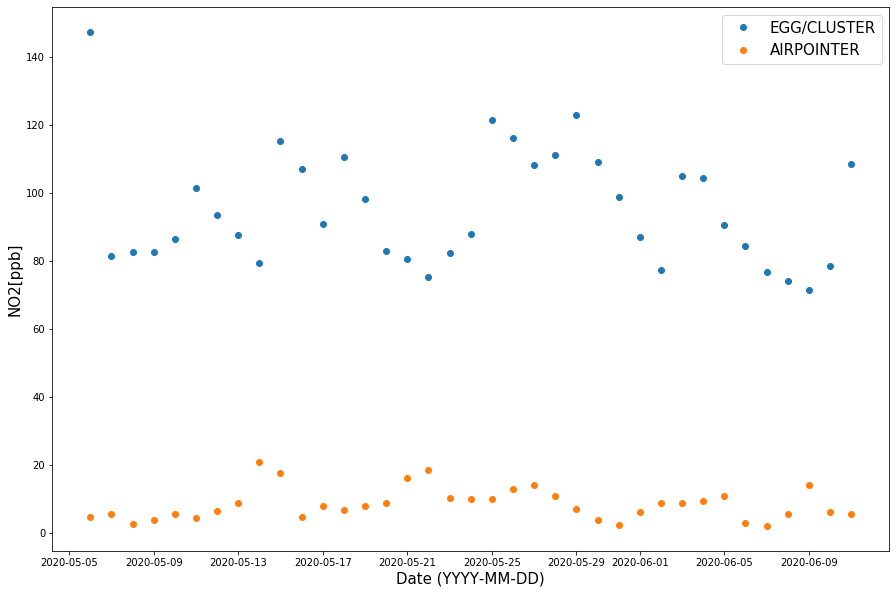

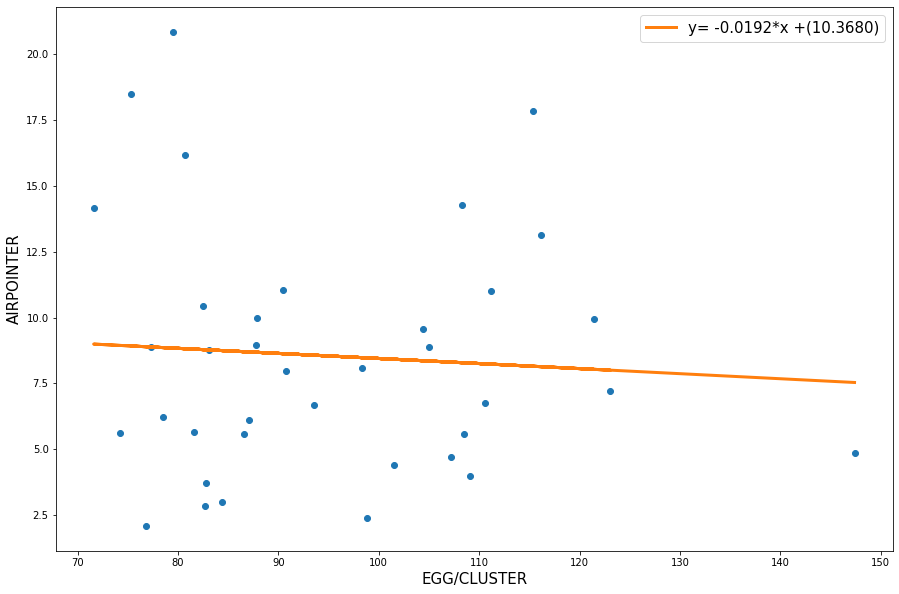

In [102]:
plt.figure(figsize=(15,10))
plt.plot(EGG2_daily.index.to_series(), EGG2_daily['NO2[ppb]'], 'o', label="EGG/CLUSTER")
plt.plot(EGG2_daily.index.to_series(), EGG2_daily['NO2'], 'o', label='AIRPOINTER')
plt.xlabel('Date (YYYY-MM-DD)', fontsize=15)
plt.ylabel('NO2[ppb]', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate a regression line
# Egg sensor
xValues = (EGG2_daily['NO2[ppb]']).to_numpy()
# Airpointer
yValues = (EGG2_daily['NO2']).to_numpy()
# Regression Line
linear_regression = LinearRegression().fit(xValues.reshape(-1,1), yValues)
# Plot the values graph with the regression line
plt.figure(figsize=(15,10))
plt.plot(xValues, yValues, 'o')
plt.plot(xValues, 
         linear_regression.predict(xValues.reshape(-1,1)),
         label='y= {:0.4f}*x +({:0.4f})'.format(linear_regression.coef_[0], linear_regression.intercept_),
         linewidth=3)
plt.xlabel('EGG/CLUSTER', fontsize=15)
plt.ylabel('AIRPOINTER', fontsize=15)
plt.legend(loc='best', fontsize=15)

# Calculate the R2 score
metrics.r2_score(yValues, linear_regression.predict(xValues.reshape(-1,1)))